In [16]:
from collections import defaultdict
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyprojroot
import seaborn as sns
import scipy.stats
import sklearn.metrics
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

import searchnets
from searchnets import nets
from searchnets.datasets import VOCDetection
from searchnets.engine.abstract_trainer import AbstractTrainer
from searchnets.transforms.util import get_transforms
from searchnets.utils.general import make_save_path

In [2]:
DATASET_TYPE = 'VOC'
LOSS_FUNCS = ['CE-largest', 'CE-random', 'BCE']

PAD_SIZE = 500

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
NUM_WORKERS = 4


class VOCEvaluator:
    """class for evaluating behavior of networks on Pascal VOC / Visual Search Difficulty dataset"""
    def __init__(self,
                 net_name,
                 model,
                 testset,
                 restore_path,
                 loss_func,
                 batch_size=64,
                 sigmoid_threshold=0.5,
                 device='cuda',
                 num_workers=NUM_WORKERS,
                 data_parallel=False,
                 ):
        self.net_name = net_name

        self.data_parallel = data_parallel
        if data_parallel:
            model = nn.DataParallel(model)

        self.restore_path = restore_path

        best_ckpt_path = restore_path.parent.joinpath(
            restore_path.name + AbstractTrainer.BEST_VAL_ACC_CKPT_SUFFIX
        )
        if not best_ckpt_path.exists():
            ckpt_path = restore_path.parent.joinpath(
                restore_path.name + AbstractTrainer.DEFAULT_CKPT_SUFFIX)
            if not ckpt_path.exists():
                raise ValueError(
                    f'did not find a checkpoint file in restore path: {restore_path}.\n'
                    f'Looked for a checkpoint saved upon best val accuracy: {best_ckpt_path.name} \n'
                    f'and for a checkpoint saved during or at the end of training: {ckpt_path.name}'
                )
            self.ckpt_path_loaded_from = ckpt_path
        else:
            self.ckpt_path_loaded_from = best_ckpt_path

        checkpoint = torch.load(self.ckpt_path_loaded_from)
        model.load_state_dict(checkpoint['model'])
        model.to(device)
        self.model = model
        self.device = device

        self.testset = testset
        self.test_loader = DataLoader(self.testset, batch_size=batch_size,
                                      shuffle=False, num_workers=num_workers,
                                      pin_memory=True)

        self.batch_size = batch_size

        self.sigmoid_threshold = sigmoid_threshold
        self.sigmoid_activation = torch.nn.Sigmoid()
        self.softmax_activation = torch.nn.Softmax()

        self.loss_func = loss_func
            
    @classmethod
    def from_config(cls,
                    net_name,
                    num_classes,
                    **kwargs):
        """factory function that creates instance of VOCEvaluator from options specified in config.ini file
        
        Parameters
        ----------
        net_name : str
            name of neural network architecture. Used when restoring model, checkpoints, etc.
        kwargs : keyword arguments

        Returns
        -------
        tester : Tester
            instance of class, initialized with passed attributes.
        """
        if net_name == 'alexnet':
            model = nets.alexnet.build(pretrained=False, progress=False, num_classes=num_classes)
        elif net_name == 'VGG16':
            model = nets.vgg16.build(pretrained=False, progress=False, num_classes=num_classes)
        elif net_name == 'CORnet_Z':
            model = nets.cornet.build(pretrained=False, num_classes=num_classes)

        kwargs = dict(**kwargs, net_name=net_name, model=model)
        return cls(**kwargs)

    def eval(self):
        """method to evaluate trained model

        Returns
        -------
        acc : float
            accuracy on test set
        pred : numpy.ndarray
            predictions for test set
        """
        self.model.eval()

        total = int(np.ceil(len(self.testset) / self.batch_size))
        # pbar = tqdm(self.test_loader)
        
        # lists of numpy arrays that get concatenated at the end, 
        # save for further analysis if required
        arrays = defaultdict(list)

        # will use with Pandas.DataFrame.from_records() 
        # to make dataframe of test results, where each row is one sample from test set
        test_records = defaultdict(list)

        # make placeholder for a tensor we create in main loop (if it doesn't exist)
        y_pred_softmax_onehot_batch = None
        
        with torch.no_grad():
            for i, batch in enumerate(self.test_loader):
                # pbar.set_description(f'batch {i} of {total}')

                # ---- get outputs ----
                x_batch, y_true_onehot_batch = batch['img'].to(self.device), batch['target'].to(self.device)
                arrays['y_true_onehot'].append(y_true_onehot_batch.cpu().numpy())
                out_batch = self.model(x_batch)
                arrays['out'].append(out_batch.cpu().numpy())  # raw output of network

                # ---- pass outputs through activation ---- 
                out_sigmoid_batch = self.sigmoid_activation(out_batch)
                arrays['out_sigmoid'].append(out_sigmoid_batch.cpu().numpy())
                out_softmax_batch = self.softmax_activation(out_batch)
                arrays['out_softmax'].append(out_sigmoid_batch.cpu().numpy())

                y_pred_sigmoid_batch = (out_sigmoid_batch > self.sigmoid_threshold).float()
                arrays['y_pred_sigmoid'].append(y_pred_sigmoid_batch.cpu().numpy())  # will use to compute F1 at end
                # compute true positive, false positive, true negative, false negative
#                 TP_sig = ((y_true_onehot_batch == 1) & (y_pred_sigmoid_batch == 1)).sum(dim=1)
#                 FP_sig = ((y_true_onehot_batch == 0) & (y_pred_sigmoid_batch == 1)).sum(dim=1)
#                 TN_sig = ((y_true_onehot_batch == 0) & (y_pred_sigmoid_batch == 0)).sum(dim=1)
#                 FN_sig = ((y_true_onehot_batch == 1) & (y_pred_sigmoid_batch == 0)).sum(dim=1)

                _, y_pred_softmax_batch = torch.max(out_softmax_batch.data, 1)
                arrays['y_pred_softmax'].append(y_pred_softmax_batch.cpu().numpy())

                # make tensor below for every batch, in case it changes size (e.g. for last batch)
                y_pred_softmax_onehot_batch = torch.FloatTensor(y_true_onehot_batch.shape).to(
                    y_true_onehot_batch.device
                )
                y_pred_softmax_onehot_batch.zero_()
                y_pred_softmax_onehot_batch.scatter_(1, torch.unsqueeze(y_pred_softmax_batch,1), 1)
#                 TP_softmax = ((y_true_onehot_batch == 1) & (y_pred_softmax_onehot_batch == 1)).sum(dim=1)
#                 FP_softmax = ((y_true_onehot_batch == 0) & (y_pred_softmax_onehot_batch == 1)).sum(dim=1)
#                 TN_softmax = ((y_true_onehot_batch == 0) & (y_pred_softmax_onehot_batch == 0)).sum(dim=1)
#                 FN_softmax = ((y_true_onehot_batch == 1) & (y_pred_softmax_onehot_batch == 0)).sum(dim=1)

                y_true_largest_batch = batch['largest'].to(self.device)
                correct_largest_batch = (y_pred_softmax_batch == y_true_largest_batch)
                arrays['correct_largest'].append(correct_largest_batch.cpu().numpy())  # will use to compute acc at end

                y_true_random_batch = batch['random'].to(self.device)
                correct_random_batch = (y_pred_softmax_batch == y_true_random_batch)
                arrays['correct_random'].append(correct_random_batch.cpu().numpy())  # will use to compute acc at end

                # now loop through each sample in batch to add to records; these will be rows in dataframe
                index_batch = batch['index']
                img_indices_list = index_batch.cpu().numpy().tolist()
                img_paths = [
                    Path(self.testset.images[idx]) for idx in img_indices_list
                ]
                img_names = [img_path.name for img_path in img_paths]
                
                vsd_score_batch = batch['vsd_score']
                rows = zip(
                    torch.unbind(index_batch),
                    img_paths,
                    img_names,
                    torch.unbind(vsd_score_batch),
#                     torch.unbind(TP_sig),
#                     torch.unbind(FP_sig),
#                     torch.unbind(TN_sig),
#                     torch.unbind(FN_sig),
#                     torch.unbind(TP_softmax),
#                     torch.unbind(FP_softmax),
#                     torch.unbind(TN_softmax),
#                     torch.unbind(FN_softmax),
                    torch.unbind(correct_largest_batch),
                    torch.unbind(correct_random_batch),
                )
                for row in rows:
                    for key, value in zip(
                        ['voc_test_index', 'img_path', 'img_name', 'vsd_score', 
#                          'TP_sig', 'FP_sig', 'TN_sig', 'FN_sig',
#                          'TP_softmax', 'FP_softmax', 'TN_softmax', 'FN_softmax',
                         'correct_largest', 'correct_random'],
                        row,
                    ):
                        if isinstance(value, torch.Tensor):
                            value = value.cpu().numpy().item()
                        test_records[key].append(value)

        arrays = {k: np.concatenate(v) for k, v in arrays.items()}
        df_test = pd.DataFrame.from_records(test_records)
                                               
        # compute f1 at end so we don't have to deal with averaging across batches
        f1 = sklearn.metrics.f1_score(y_true=arrays['y_true_onehot'],
                                      y_pred=arrays['y_pred_sigmoid'],
                                      average='macro')
        # do same with other metrics just for consistency
        acc_largest = arrays['correct_largest'].sum() / arrays['correct_largest'].size
        acc_random = arrays['correct_random'].sum() / arrays['correct_random'].size

        return {
            'arrays': arrays,
            'df_test': df_test,
            'f1': f1,
            'acc_largest': acc_largest,
            'acc_random': acc_random,
        }

In [5]:
def eval_one_net(cfg, net_number=1):
    # will use with Pandas.DataFrame.from_records() 
    # to make dataframe of test results, where each row is one training replicate
    replicate_records = defaultdict(list)
    
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    print(f'device: {device}')

    assert len(cfg.train.epochs_list) == 1
    epochs = cfg.train.epochs_list[0]

    transform, target_transform = get_transforms(cfg.data.dataset_type, 
                                                 loss_func=cfg.train.loss_func,
                                                 pad_size=cfg.data.pad_size)

    testset = VOCDetection(root=cfg.data.root,
                           csv_file=cfg.data.csv_file_out,
                           image_set='trainval',
                           split='test',
                           download=True,
                           transform=transform,
                           target_transform=target_transform
                           )

    restore_path_this_net = make_save_path(cfg.train.save_path, cfg.train.net_name, net_number, epochs)

    print(f'Loading model from {restore_path_this_net}')
    evaluator = VOCEvaluator.from_config(net_name=cfg.train.net_name,
                                         testset=testset,
                                         restore_path=restore_path_this_net,
                                         num_classes=cfg.data.num_classes,
                                         batch_size=cfg.train.batch_size,
                                         device=device,
                                         num_workers=cfg.train.num_workers,
                                         data_parallel=cfg.train.data_parallel,
                                         loss_func=cfg.train.loss_func)

    return evaluator.eval()

In [6]:
def eval_one_config(cfg):
    df_test_list = []

    for net_number in range(1, cfg.train.number_nets_to_train + 1):
        print(f'running evaluator on replicate {net_number}')
        results = eval_one_net(cfg, net_number)
        df_test = results['df_test']
        df_test['replicate'] = net_number
        df_test['loss_func'] = cfg.train.loss_func
        df_test['n_items'] = results['arrays']['y_true_onehot'].sum(axis=1).astype(int)
        df_test_list.append(df_test)

    df_test_all = pd.concat(df_test_list)
        
    return df_test_all

In [7]:
VSD_CONFIGS_ROOT = pyprojroot.here('./data/configs/VSD')
VSD_CONFIG_INIS = sorted(VSD_CONFIGS_ROOT.glob('*.ini'))

In [8]:
ALEXNET_VSD_CONFIG_INIS = [vsd_config for vsd_config in VSD_CONFIG_INIS if 'alexnet' in str(vsd_config) and 'transfer' in str(vsd_config)]

In [9]:
CORNET_Z_VSD_CONFIG_INIS = [vsd_config for vsd_config in VSD_CONFIG_INIS if 'CORnet_Z' in str(vsd_config) and 'transfer' in str(vsd_config)]

In [27]:
VGG16_VSD_TRANSFER_CONFIGS = [vsd_config for vsd_config in VSD_CONFIG_INIS if 'VGG16' in str(vsd_config) and 'transfer' in str(vsd_config)]

In [28]:
VGG16_VSD_TRANSFER_CONFIGS

[PosixPath('/home/bart/Documents/repos/L2M/visual-search-nets/data/configs/VSD/VSD_VGG16_transfer_BCE.ini'),
 PosixPath('/home/bart/Documents/repos/L2M/visual-search-nets/data/configs/VSD/VSD_VGG16_transfer_CE_largest.ini'),
 PosixPath('/home/bart/Documents/repos/L2M/visual-search-nets/data/configs/VSD/VSD_VGG16_transfer_CE_random.ini')]

In [29]:
VGG16_VSD_INITIALIZE_CONFIGS = [vsd_config for vsd_config in VSD_CONFIG_INIS if 'VGG16' in str(vsd_config) and 'initialize' in str(vsd_config)]

In [30]:
VGG16_VSD_INITIALIZE_CONFIGS

[PosixPath('/home/bart/Documents/repos/L2M/visual-search-nets/data/configs/VSD/VSD_VGG16_initialize_BCE.ini'),
 PosixPath('/home/bart/Documents/repos/L2M/visual-search-nets/data/configs/VSD/VSD_VGG16_initialize_CE_largest.ini')]

In [24]:
configfile = VGG16_VSD_CONFIG_INIS[1]
cfg = searchnets.config.parse_config(configfile)

In [25]:
results = eval_one_net(cfg, net_number=1)

device: cuda
Using downloaded and verified file: /home/bart/Documents/data/voc/VOCtrainval_11-May-2012.tar
Loading model from /home/bart/Documents/repos/L2M/visual-search-nets/results/VSD/checkpoints/VGG16_transfer_CE_largest/trained_200_epochs/net_number_1/VGG16_trained_200_epochs_number_1


/home/bart/anaconda3/envs/searchnets-torch1.3/lib/python3.6/site-packages/ipykernel_launcher.py:128: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [34]:
def df_test_from_configfile(configfile):
    cfg = searchnets.config.parse_config(configfile)
    
    all_dfs = []
    for net_number in range(1, cfg.train.number_nets_to_train + 1):
        results = eval_one_net(cfg, net_number=net_number)
        
        arrays = results['arrays']
        entropy_softmax = []
        for row in arrays['out_sigmoid']:
            entropy_softmax.append(
                scipy.stats.entropy(row)
            )

        df = results['df_test']
        df['entropy'] = np.asarray(entropy_softmax)
        
        df['net_number'] = net_number
        all_dfs.append(df)

    test_df = pd.concat(all_dfs)
    return test_df

In [35]:
df_test_vgg16_transfer = df_test_from_configfile(configfile=VGG16_VSD_TRANSFER_CONFIGS[1])

device: cuda
Using downloaded and verified file: /home/bart/Documents/data/voc/VOCtrainval_11-May-2012.tar
Loading model from /home/bart/Documents/repos/L2M/visual-search-nets/results/VSD/checkpoints/VGG16_transfer_CE_largest/trained_200_epochs/net_number_1/VGG16_trained_200_epochs_number_1


/home/bart/anaconda3/envs/searchnets-torch1.3/lib/python3.6/site-packages/ipykernel_launcher.py:128: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


device: cuda
Using downloaded and verified file: /home/bart/Documents/data/voc/VOCtrainval_11-May-2012.tar
Loading model from /home/bart/Documents/repos/L2M/visual-search-nets/results/VSD/checkpoints/VGG16_transfer_CE_largest/trained_200_epochs/net_number_2/VGG16_trained_200_epochs_number_2
device: cuda
Using downloaded and verified file: /home/bart/Documents/data/voc/VOCtrainval_11-May-2012.tar
Loading model from /home/bart/Documents/repos/L2M/visual-search-nets/results/VSD/checkpoints/VGG16_transfer_CE_largest/trained_200_epochs/net_number_3/VGG16_trained_200_epochs_number_3
device: cuda
Using downloaded and verified file: /home/bart/Documents/data/voc/VOCtrainval_11-May-2012.tar
Loading model from /home/bart/Documents/repos/L2M/visual-search-nets/results/VSD/checkpoints/VGG16_transfer_CE_largest/trained_200_epochs/net_number_4/VGG16_trained_200_epochs_number_4
device: cuda
Using downloaded and verified file: /home/bart/Documents/data/voc/VOCtrainval_11-May-2012.tar
Loading model fro

In [36]:
df_test_vgg16_initialize = df_test_from_configfile(configfile=VGG16_VSD_INITIALIZE_CONFIGS[1])

device: cuda
Using downloaded and verified file: /home/bart/Documents/data/voc/VOCtrainval_11-May-2012.tar
Loading model from /home/bart/Documents/repos/L2M/visual-search-nets/results/VSD/checkpoints/VGG16_initialize_CE_largest/trained_200_epochs/net_number_1/VGG16_trained_200_epochs_number_1


/home/bart/anaconda3/envs/searchnets-torch1.3/lib/python3.6/site-packages/ipykernel_launcher.py:128: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


device: cuda
Using downloaded and verified file: /home/bart/Documents/data/voc/VOCtrainval_11-May-2012.tar
Loading model from /home/bart/Documents/repos/L2M/visual-search-nets/results/VSD/checkpoints/VGG16_initialize_CE_largest/trained_200_epochs/net_number_2/VGG16_trained_200_epochs_number_2
device: cuda
Using downloaded and verified file: /home/bart/Documents/data/voc/VOCtrainval_11-May-2012.tar
Loading model from /home/bart/Documents/repos/L2M/visual-search-nets/results/VSD/checkpoints/VGG16_initialize_CE_largest/trained_200_epochs/net_number_3/VGG16_trained_200_epochs_number_3
device: cuda
Using downloaded and verified file: /home/bart/Documents/data/voc/VOCtrainval_11-May-2012.tar
Loading model from /home/bart/Documents/repos/L2M/visual-search-nets/results/VSD/checkpoints/VGG16_initialize_CE_largest/trained_200_epochs/net_number_4/VGG16_trained_200_epochs_number_4
device: cuda
Using downloaded and verified file: /home/bart/Documents/data/voc/VOCtrainval_11-May-2012.tar
Loading mod

/home/bart/anaconda3/envs/searchnets-torch1.3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


device: cuda
Using downloaded and verified file: /home/bart/Documents/data/voc/VOCtrainval_11-May-2012.tar
Loading model from /home/bart/Documents/repos/L2M/visual-search-nets/results/VSD/checkpoints/VGG16_initialize_CE_largest/trained_200_epochs/net_number_8/VGG16_trained_200_epochs_number_8


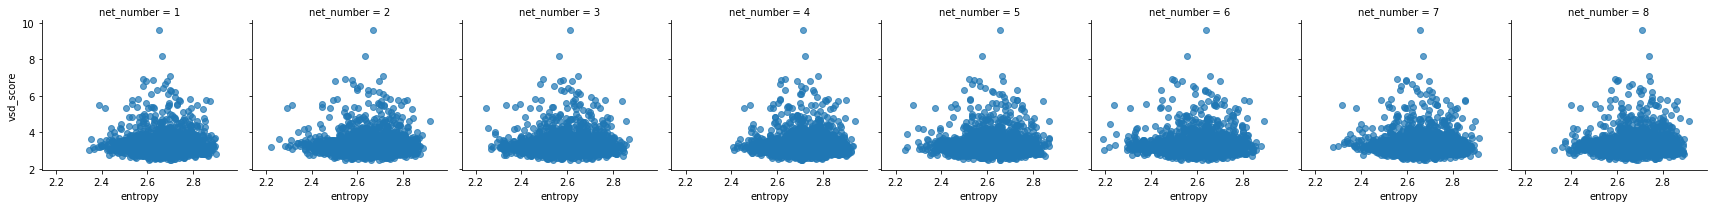

In [40]:
g = sns.FacetGrid(df_test_vgg16_transfer, col="net_number")
g.map(plt.scatter, "entropy", "vsd_score", alpha=.7)
g.add_legend();


# sns.scatterplot(x='entropy', y='vsd_score', hue='net_number', data=df_test_vgg16_transfer)

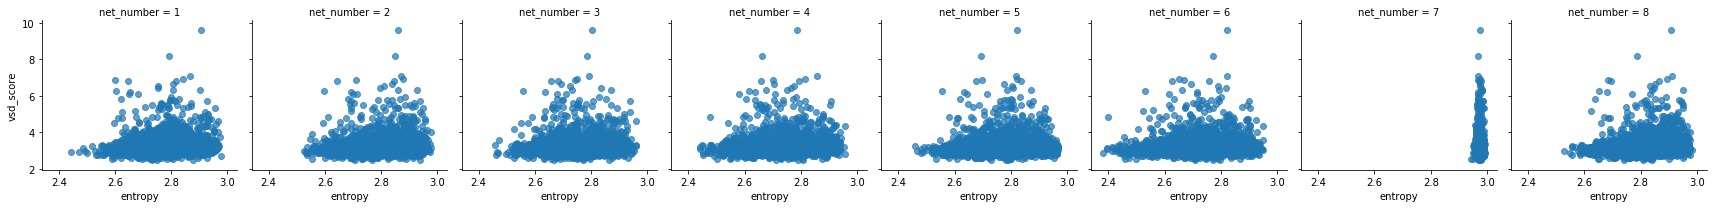

In [41]:
g = sns.FacetGrid(df_test_vgg16_initialize, col="net_number")
g.map(plt.scatter, "entropy", "vsd_score", alpha=.7)
g.add_legend();


In [51]:
def taus_from_df(df):
    taus = []
    
    for net_number in df['net_number'].unique():
        df_net = df[df['net_number'] == net_number]
        tau = scipy.stats.kendalltau(x=df_net['entropy'].values, y=df_net['vsd_score'].values)
        taus.append(tau)
    
    return taus

In [53]:
taus_transfer = taus_from_df(df_test_vgg16_transfer)
print([tau.correlation for tau in taus_transfer])

[0.011859497651946207, 0.02463748438185371, 0.031851028778054215, 0.029823020935266006, 0.03050929892141771, 0.016917846551440217, -0.0033593844402321628, 0.051788851614272165]


In [54]:
taus_initialize = taus_from_df(df_test_vgg16_initialize)
print([tau.correlation for tau in taus_initialize])

[0.08463617482558698, 0.09286797393330168, 0.061396327789867575, 0.06004110788016256, 0.05296148029069233, 0.05295257391056964, -0.02375835101840643, 0.10431795569332514]


In [27]:
out_softmax_true = []

for ind, row in enumerate(arrays['y_true_onehot']):
    out_softmax_true.append(
        arrays['out_softmax'][ind, :][row.astype(bool)]
    )

out_softmax_true_mean = np.asarray(
    [np.mean(row) for row in out_softmax_true]
)

out_softmax_true_median = np.asarray(
    [np.median(row) for row in out_softmax_true]
)

In [28]:
results['df_test']['out_sigmoid_true_mean'] = out_sig_true_mean
results['df_test']['out_sigmoid_true_median'] = out_sig_true_median
results['df_test']['out_softmax_true_mean'] = out_softmax_true_mean
results['df_test']['out_softmax_true_median'] = out_softmax_true_median

In [31]:
results['df_test'].columns

Index(['FN_sig', 'FN_softmax', 'FP_sig', 'FP_softmax', 'TN_sig', 'TN_softmax',
       'TP_sig', 'TP_softmax', 'correct_largest', 'correct_random', 'img_name',
       'img_path', 'voc_test_index', 'vsd_score', 'out_sigmoid_true_mean',
       'out_sigmoid_true_median', 'out_softmax_true_mean',
       'out_softmax_true_median'],
      dtype='object')

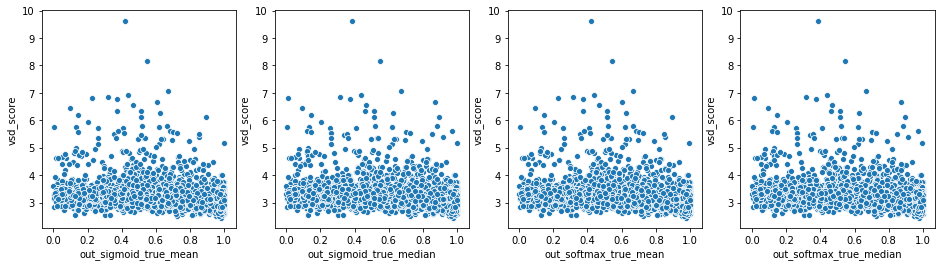

In [34]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax = ax.ravel()

for ind, col in enumerate(['out_sigmoid_true_mean', 'out_sigmoid_true_median', 'out_softmax_true_mean', 'out_softmax_true_median']):
    sns.scatterplot(x=col, y='vsd_score', data=results['df_test'], ax=ax[ind])

In [37]:
test_df = []
for configfile in ALEXNET_VSD_CONFIG_INIS:
    cfg = searchnets.config.parse_config(configfile)
    test_df.append(
        eval_one_config(cfg)
    )
test_df = pd.concat(test_df)

running evaluator on replicate 1
device: cuda
Using downloaded and verified file: /home/bart/Documents/data/voc/VOCtrainval_11-May-2012.tar
Loading model from /home/bart/Documents/repos/L2M/visual-search-nets/results/checkpoints/VSD_alexnet_transfer_BCE/trained_200_epochs/net_number_1/alexnet_trained_200_epochs_number_1


/home/bart/anaconda3/envs/searchnets-torch/lib/python3.6/site-packages/ipykernel_launcher.py:128: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


running evaluator on replicate 2
device: cuda
Using downloaded and verified file: /home/bart/Documents/data/voc/VOCtrainval_11-May-2012.tar
Loading model from /home/bart/Documents/repos/L2M/visual-search-nets/results/checkpoints/VSD_alexnet_transfer_BCE/trained_200_epochs/net_number_2/alexnet_trained_200_epochs_number_2
running evaluator on replicate 3
device: cuda
Using downloaded and verified file: /home/bart/Documents/data/voc/VOCtrainval_11-May-2012.tar
Loading model from /home/bart/Documents/repos/L2M/visual-search-nets/results/checkpoints/VSD_alexnet_transfer_BCE/trained_200_epochs/net_number_3/alexnet_trained_200_epochs_number_3
running evaluator on replicate 4
device: cuda
Using downloaded and verified file: /home/bart/Documents/data/voc/VOCtrainval_11-May-2012.tar
Loading model from /home/bart/Documents/repos/L2M/visual-search-nets/results/checkpoints/VSD_alexnet_transfer_BCE/trained_200_epochs/net_number_4/alexnet_trained_200_epochs_number_4
running evaluator on replicate 5
d

In [38]:
len(test_df)

69216

In [39]:
test_df.head()

,FN_sig,FN_softmax,FP_sig,FP_softmax,TN_sig,TN_softmax,TP_sig,TP_softmax,correct_largest,correct_random,img_name,img_path,voc_test_index,vsd_score,replicate,loss_func,n_items
0,0,0,0,0,19,19,1,1,True,True,2008_000015.jpg,/home/bart/Documents/data/voc/VOCdevkit/VOC201...,0,3.709118,1,BCE,1
1,1,0,0,0,19,19,0,1,True,True,2008_000016.jpg,/home/bart/Documents/data/voc/VOCdevkit/VOC201...,1,4.000782,1,BCE,1
2,1,2,0,0,17,17,2,1,False,False,2008_000023.jpg,/home/bart/Documents/data/voc/VOCdevkit/VOC201...,2,3.362935,1,BCE,3
3,0,0,0,0,19,19,1,1,True,True,2008_000033.jpg,/home/bart/Documents/data/voc/VOCdevkit/VOC201...,3,3.159318,1,BCE,1
4,1,2,0,0,17,17,2,1,False,False,2008_000036.jpg,/home/bart/Documents/data/voc/VOCdevkit/VOC201...,4,3.364060,1,BCE,3


In [62]:
test_df['acc_sig'] = (test_df['TP_sig'] + test_df['TN_sig']) / (test_df['TP_sig'] + test_df['TN_sig'] + test_df['FP_sig'] + test_df['FN_sig'])
test_df['acc_softmax'] = (test_df['TP_softmax'] + test_df['TN_softmax']) / (test_df['TP_softmax'] + test_df['TN_softmax'] + test_df['FP_softmax'] + test_df['FN_softmax'])
test_df['err_sig'] = 1 - test_df['acc_sig']
test_df['err_softmax'] = 1 - test_df['acc_softmax']

In [40]:
def acc_sig_df(df):
    return (df['TP_sig'].sum() + df['TN_sig'].sum()) / (df['TP_sig'].sum() + df['TN_sig'].sum() + df['FP_sig'].sum() + df['FN_sig'].sum())

In [41]:
def acc_softmax_df(df):
    return (df['TP_softmax'].sum() + df['TN_softmax'].sum()) / (df['TP_softmax'].sum() + df['TN_softmax'].sum() + df['FP_softmax'].sum() + df['FN_softmax'].sum())

In [42]:
def acc_by_n_item(df, max_n_item=4):
    records = defaultdict(list)
    for n_item in range(1, max_n_item + 1):
        records['n_item'].append(n_item)
        df_test_item_n = df[df['n_items'] == n_item]
        records['acc_sig'].append(acc_sig_df(df_test_item_n))
        records['acc_softmax'].append(acc_softmax_df(df_test_item_n))
        records['mean_vsd_score'].append(df_test_item_n['vsd_score'].mean())
        records['median_vsd_score'].append(df_test_item_n['vsd_score'].median())
    return pd.DataFrame.from_records(records)

In [43]:
dfs = []

for loss_func in test_df['loss_func'].unique():
    df_this_loss_func = test_df[test_df['loss_func'] == loss_func]
    df_acc_by_n_item_this_loss_func = acc_by_n_item(df_this_loss_func)
    df_acc_by_n_item_this_loss_func['loss_func'] = loss_func
    dfs.append(df_acc_by_n_item_this_loss_func)
df_acc_by_n_item = pd.concat(dfs)

In [44]:
df_acc_by_n_item

,acc_sig,acc_softmax,mean_vsd_score,median_vsd_score,n_item,loss_func
0,0.968646,0.969323,3.168365,3.118631,1,BCE
1,0.937112,0.933607,3.443818,3.298614,2,BCE
2,0.903517,0.889727,3.577412,3.430000,3,BCE
3,0.881798,0.846053,3.718485,3.500000,4,BCE
0,0.591668,0.972226,3.168365,3.118631,1,CE-largest
1,0.637318,0.927296,3.443818,3.298614,2,CE-largest
2,0.675481,0.882844,3.577412,3.430000,3,CE-largest
3,0.726425,0.837061,3.718485,3.500000,4,CE-largest
0,0.578982,0.971309,3.168365,3.118631,1,CE-random
1,0.618111,0.931265,3.443818,3.298614,2,CE-random


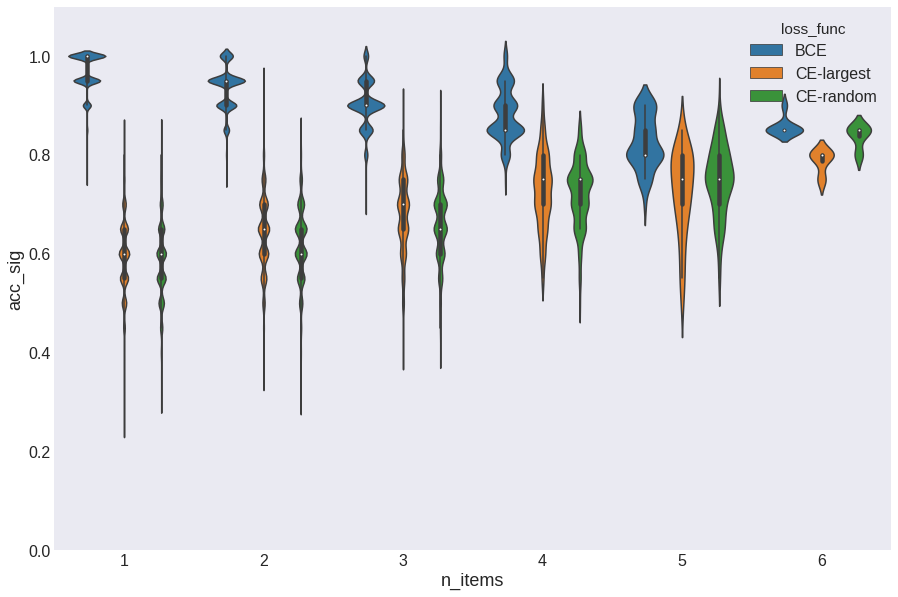

In [58]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.violinplot(x='n_items', y='acc_sig', hue='loss_func', data=test_df);
ax.set_ylim([0.0, 1.1]);

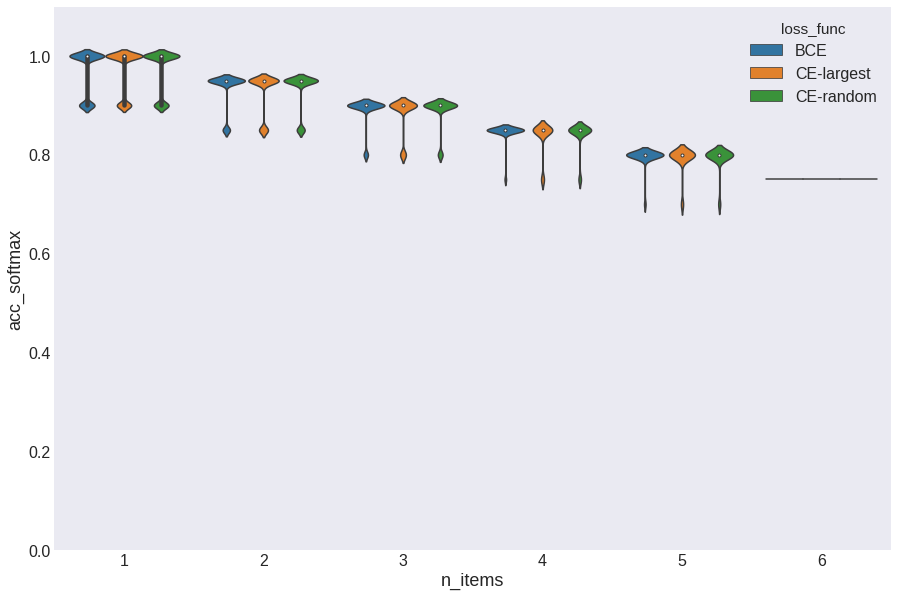

In [60]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.violinplot(x='n_items', y='acc_softmax', hue='loss_func', data=test_df);
ax.set_ylim([0.0, 1.1]);

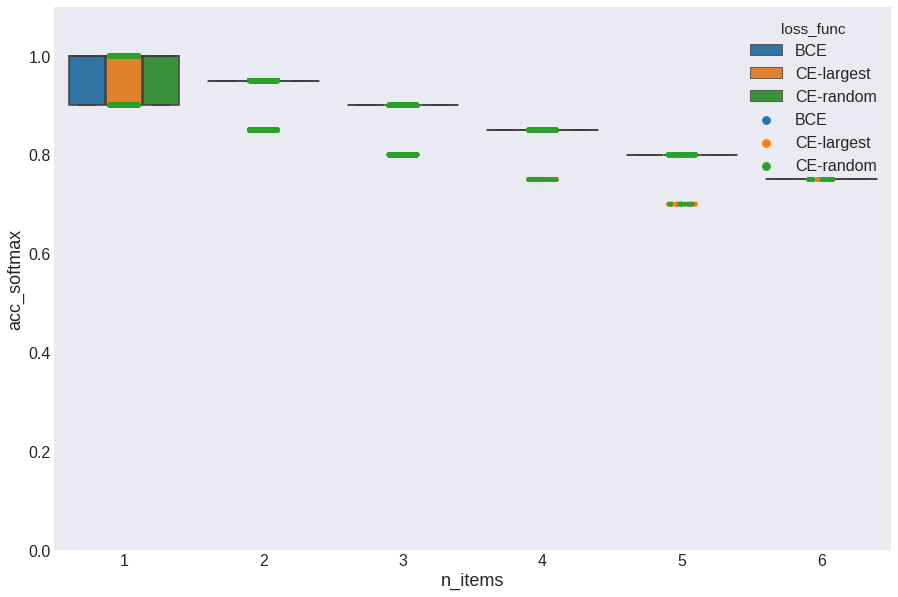

In [97]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(x='n_items', y='acc_softmax', hue='loss_func', data=test_df, showfliers=False, ax=ax);
sns.stripplot(x='n_items', y='acc_softmax', hue='loss_func', data=test_df);
ax.set_ylim([0.0, 1.1]);

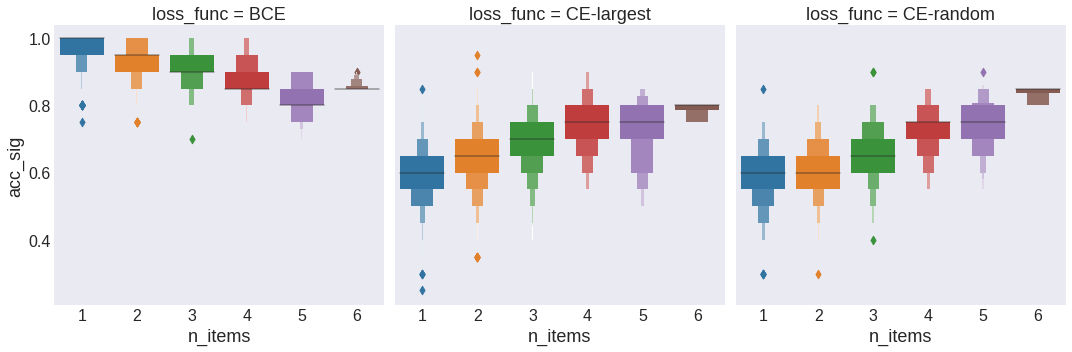

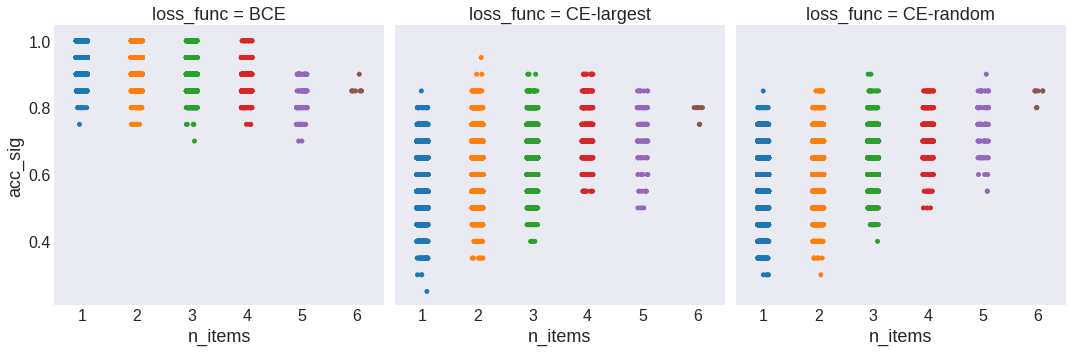

In [104]:
ax = sns.catplot(x='n_items', y='acc_sig', col='loss_func', kind="boxen", data=test_df);
ax = sns.catplot(x='n_items', y='acc_sig', col='loss_func', kind="strip", data=test_df);

In [112]:
test_df["acc_sig"].unique()

array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.55, 0.6 , 0.5 , 0.65,
       0.45, 0.4 , 0.35, 0.3 , 0.25])

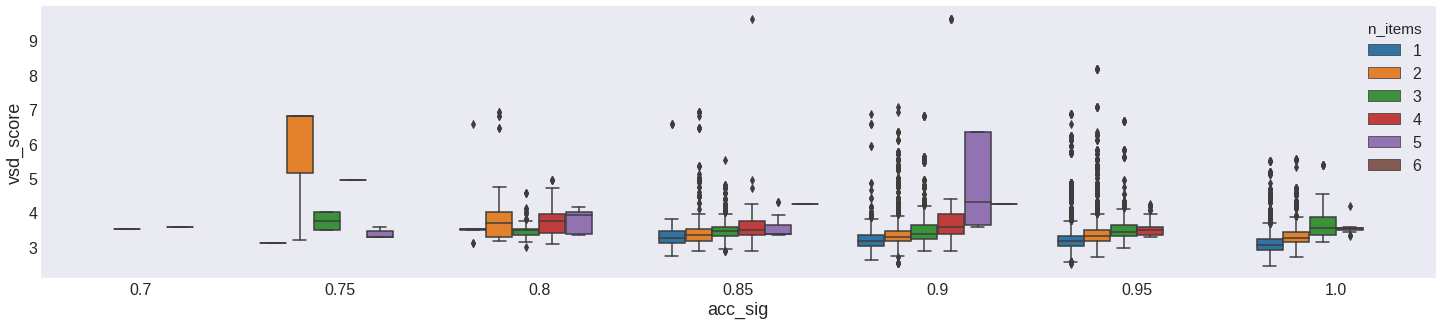

In [146]:
fig, ax = plt.subplots(figsize=(25,5))
sns.boxplot(x="acc_sig", y="vsd_score", hue="n_items", data=test_df[test_df['loss_func'] == 'BCE']);

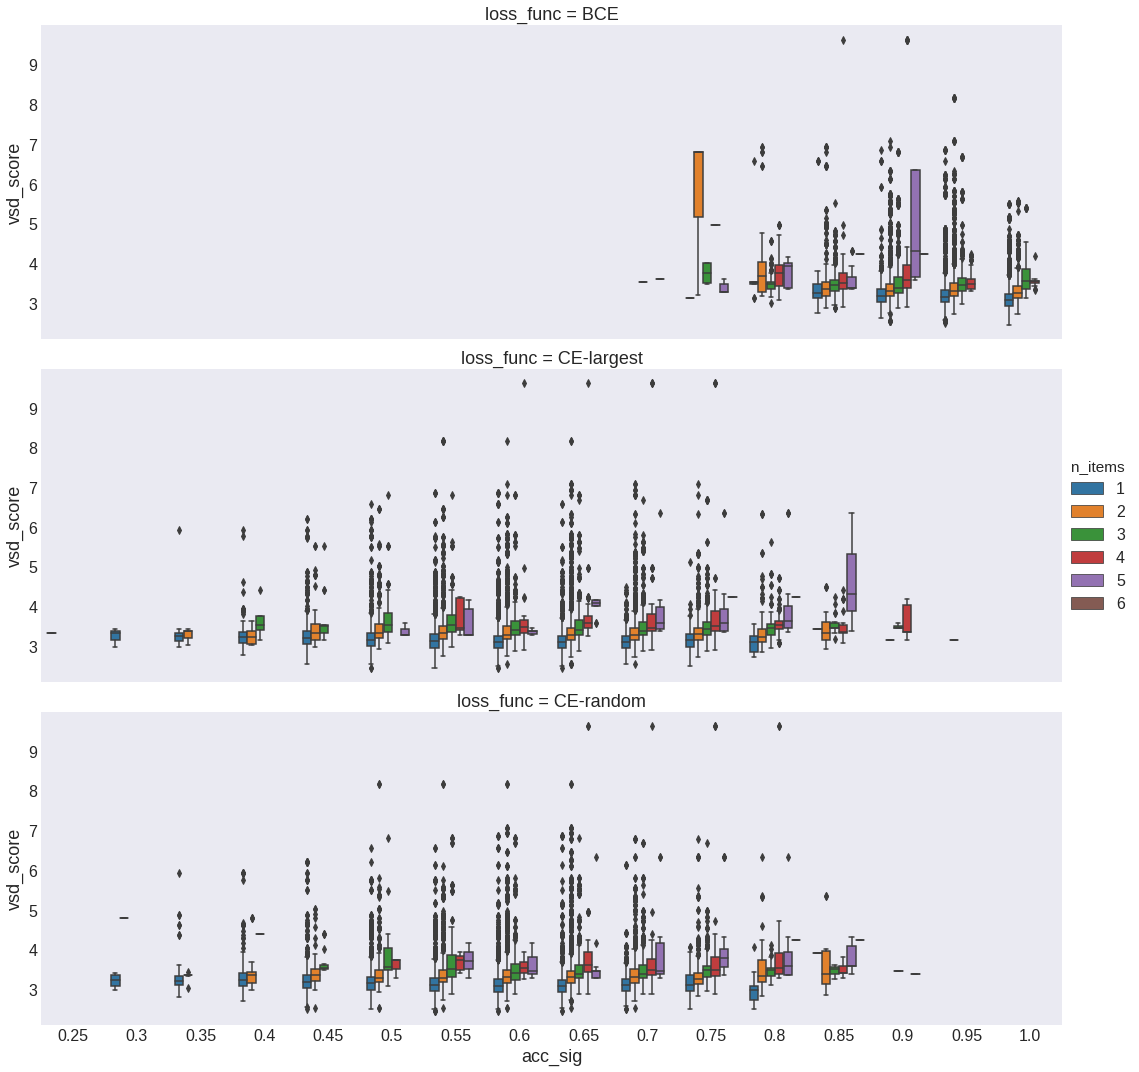

In [130]:
sns.catplot(x="acc_sig", y="vsd_score", row="loss_func", kind="box", hue="n_items", data=test_df, height=5, aspect=3);

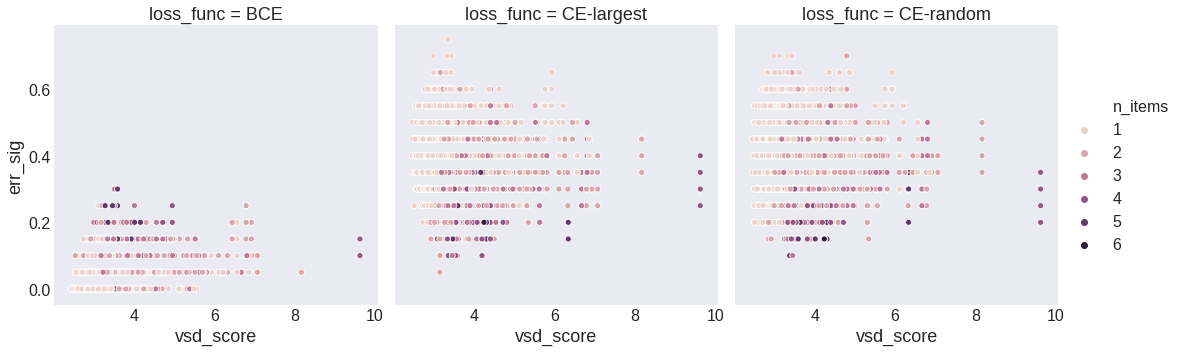

In [157]:
cmap = sns.color_palette("Blues")
ax = sns.relplot(x="vsd_score", y="err_sig", hue="n_items", col="loss_func", legend="full", data=test_df, cmap=cmap);

## is there a relationship between number of items and visual difficulty score

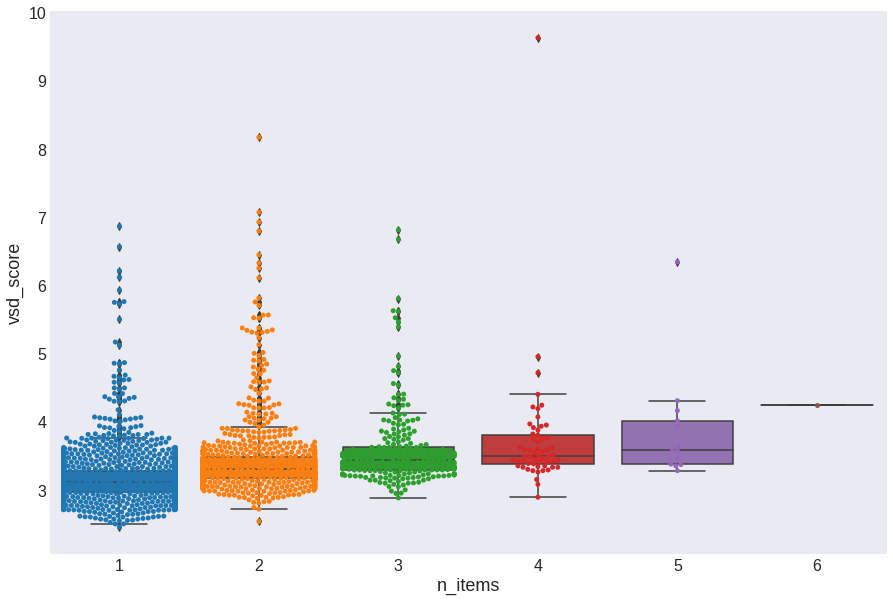

In [77]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(x="n_items", y="vsd_score", data=test_df[(test_df['loss_func']=='BCE') & (test_df['replicate']==1)], ax=ax)
sns.swarmplot(x="n_items", y="vsd_score", data=test_df[(test_df['loss_func']=='BCE') & (test_df['replicate']==1)], ax=ax)

box plot + swarm plot suggest that yes, visual difficulty score does increase as the number of items increases.

However it's also clear that there's many more images with just one item, and that the range of VSD scores is quite wide for images with one item.

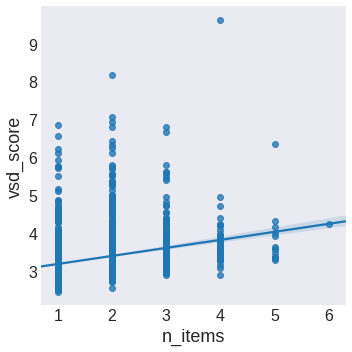

In [80]:
sns.lmplot(x="n_items", y="vsd_score", data=test_df[(test_df['loss_func']=='BCE') & (test_df['replicate']==1)])

In [82]:
Linear regression tells a similar story

SyntaxError: invalid syntax (<ipython-input-82-ebb91187cb23>, line 1)

## Does taking argmax of the softmax output automatically give us 
If we compute accuracy per image, and we can only accurately classify at most one of the classes present, as is the case for classifying by taking the arg max of the soft max output of a network, then there are a fixed number of accuracies for any given image, and 

This is a consequence of how accuracy is computed in this context.  
But to make this point extra clear we can compute unique values for each number of items, and verify it holds true regardless of loss function.

In [90]:
for loss_func in test_df['loss_func'].unique():
    for n_items in sorted(test_df['n_items'].unique()):
        softmax_acc_vals = data=test_df[(test_df['loss_func']==loss_func) & (test_df['n_items']==n_items)]['acc_softmax'].values
        uniq_softmax_acc, counts = np.unique(softmax_acc_vals, return_counts=True)
        print(
            f'unique values for softmax accuracy on image with {n_items} items when trained with {loss_func} loss function:]\n'
            f'{uniq_softmax_acc}.\nCounts: {counts}'
        )

unique values for softmax accuracy on image with 1 items when trained with BCE loss function:]
[0.9 1. ].
Counts: [4280 9672]
unique values for softmax accuracy on image with 2 items when trained with BCE loss function:]
[0.85 0.95].
Counts: [1078 5498]
unique values for softmax accuracy on image with 3 items when trained with BCE loss function:]
[0.8 0.9].
Counts: [ 203 1773]
unique values for softmax accuracy on image with 4 items when trained with BCE loss function:]
[0.75 0.85].
Counts: [ 18 438]
unique values for softmax accuracy on image with 5 items when trained with BCE loss function:]
[0.7 0.8].
Counts: [  4 100]
unique values for softmax accuracy on image with 6 items when trained with BCE loss function:]
[0.75].
Counts: [8]
unique values for softmax accuracy on image with 1 items when trained with CE-largest loss function:]
[0.9 1. ].
Counts: [ 3875 10077]
unique values for softmax accuracy on image with 2 items when trained with CE-largest loss function:]
[0.85 0.95].
Count

What about when we take a threshold on the sigmoid activation?

In [91]:
for loss_func in test_df['loss_func'].unique():
    for n_items in sorted(test_df['n_items'].unique()):
        softmax_acc_vals = data=test_df[(test_df['loss_func']==loss_func) & (test_df['n_items']==n_items)]['acc_sig'].values
        uniq_softmax_acc, counts = np.unique(softmax_acc_vals, return_counts=True)
        print(
            f'unique values for sigmoid accuracy on image with {n_items} items when trained with {loss_func} loss function:]\n'
            f'{uniq_softmax_acc}.\nCounts: {counts}'
        )

unique values for sigmoid accuracy on image with 1 items when trained with BCE loss function:]
[0.75 0.8  0.85 0.9  0.95 1.  ].
Counts: [   1   11  184 1514 5120 7122]
unique values for sigmoid accuracy on image with 2 items when trained with BCE loss function:]
[0.75 0.8  0.85 0.9  0.95 1.  ].
Counts: [   7   42  467 1728 3211 1121]
unique values for sigmoid accuracy on image with 3 items when trained with BCE loss function:]
[0.7  0.75 0.8  0.85 0.9  0.95 1.  ].
Counts: [  1   4  80 358 980 433 120]
unique values for sigmoid accuracy on image with 4 items when trained with BCE loss function:]
[0.75 0.8  0.85 0.9  0.95 1.  ].
Counts: [  3  45 187 118  86  17]
unique values for sigmoid accuracy on image with 5 items when trained with BCE loss function:]
[0.7  0.75 0.8  0.85 0.9 ].
Counts: [ 2 15 41 21 25]
unique values for sigmoid accuracy on image with 6 items when trained with BCE loss function:]
[0.85 0.9 ].
Counts: [7 1]
unique values for sigmoid accuracy on image with 1 items when